In [13]:
%matplotlib inline
import sys
from refer import REFER
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import json

In [14]:
def show_image(image):
    height = image.shape[0]
    width = image.shape[1]
    
    margin=50 # pixels
    dpi=100. # dots per inch

    figsize=((width+2*margin)/dpi, (height+2*margin)/dpi) # inches
    left = margin/dpi/figsize[0] #axes ratio
    bottom = margin/dpi/figsize[1]

    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom)

    plt.imshow(image)
    plt.show()

In [2]:
data_root = 'data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=8.10s)


In [16]:
ref_id=254
ref = refer.Refs[ref_id]
image_file_name = '../refer/data/images/mscoco/images/train2014' + '/' + refer.Imgs[ref['image_id']]['file_name']
# x,y,w,h=refer.getRefBox(ref_id)
# image = cv2.imread(image_file_name)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# show_image(image)

In [51]:
filter_keywords = set([
                   'left', 'right', 'top', 'bottom', 
                   'middle', 'big', 'small', 'long', 'short', 'tall', 'huge', 'tiny',
                   'blue', 'green', 'red', 'yellow', 'pink', 'purple', 'orange', 'black', 'gray', 'white', 'brown'])

filtered_ref_ids = set()
train_ref_ids = refer.getRefIds()
for ref_id in tqdm(train_ref_ids):
    ref = refer.Refs[ref_id]
    for sentence in ref['sentences']:
        if len(set(sentence['tokens']) & filter_keywords) > 0:
            filtered_ref_ids.add(ref_id)
len(filtered_ref_ids)


100%|██████████| 50000/50000 [00:00<00:00, 182889.99it/s]

43025

In [11]:
with open('mscoco-annotations/captions_train2014.json') as data_file:    
    mscoco_captions = json.load(data_file)

image_annotations = {}
for annotation in mscoco_captions['annotations']:
    sentence = annotation['caption']
    sentence = sentence.strip(' ,.')
    tokens = [token.lower() for token in sentence.split(' ')]
    tokens.insert(0, '<BOS>')
    tokens.append('<EOS>')
    if annotation['image_id'] in image_annotations:
        image_annotations[annotation['image_id']].append(tokens)
    else:
        image_annotations[annotation['image_id']] = list()
        image_annotations[annotation['image_id']].append(tokens)
        
mscoco_images = {}
for image in mscoco_captions['images']:
    mscoco_images[image['id']] = image['file_name']

In [12]:
image_annotations

{318556: [['<BOS>',
   'a',
   'very',
   'clean',
   'and',
   'well',
   'decorated',
   'empty',
   'bathroom',
   '<EOS>'],
  ['<BOS>',
   'a',
   'blue',
   'and',
   'white',
   'bathroom',
   'with',
   'butterfly',
   'themed',
   'wall',
   'tiles',
   '<EOS>'],
  ['<BOS>',
   'a',
   'bathroom',
   'with',
   'a',
   'border',
   'of',
   'butterflies',
   'and',
   'blue',
   'paint',
   'on',
   'the',
   'walls',
   'above',
   'it',
   '<EOS>'],
  ['<BOS>',
   'an',
   'angled',
   'view',
   'of',
   'a',
   'beautifully',
   'decorated',
   'bathroom',
   '<EOS>'],
  ['<BOS>',
   'a',
   'clock',
   'that',
   'blends',
   'in',
   'with',
   'the',
   'wall',
   'hangs',
   'in',
   'a',
   'bathroom',
   '<EOS>']],
 116100: [['<BOS>',
   'a',
   'panoramic',
   'view',
   'of',
   'a',
   'kitchen',
   'and',
   'all',
   'of',
   'its',
   'appliances',
   '<EOS>'],
  ['<BOS>',
   'a',
   'panoramic',
   'photo',
   'of',
   'a',
   'kitchen',
   'and',
   'dining',


In [13]:
image_refs = {}
for ref_id in images_features:
    ref = refer.Refs[ref_id]
    image_refs[ref['image_id']] = ref_id

In [14]:
train_ref_ids = refer.getRefIds()
vocab = set(('<BOS>','<EOS>'))

word_to_index = {'<BOS>':0,'<EOS>':1}

for ref_id in tqdm(train_ref_ids):
    ref = refer.Refs[ref_id]
    for sentence in ref['sentences']:
        vocab.update(sentence['tokens'])
        for token in sentence['tokens']:
            if token not in word_to_index:
                word_to_index[token] = len(word_to_index)

for image_id in tqdm(image_annotations):
    sentences = image_annotations[image_id]
    for tokens in sentences:
        vocab.update(tokens)
        for token in tokens:
            if token not in word_to_index:
                word_to_index[token] = len(word_to_index)
                
def prepare_sequence(seq, to_index):
    indices = [to_index[w] for w in seq]
    tensor = torch.LongTensor(indices)
    return autograd.Variable(tensor)

100%|██████████| 82783/82783 [00:01<00:00, 43207.16it/s]


In [15]:
class MyNetwork(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(MyNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_lang = nn.LSTM(embedding_dim, hidden_dim)
        self.lstm_local = nn.LSTM(hidden_dim + 1000 + 8, hidden_dim)
        self.lstm_global = nn.LSTM(hidden_dim + 1000, hidden_dim)
        
        self.h_lang = self.init_hidden()
        self.h_local = self.init_hidden()
        self.h_global = self.init_hidden()
        
#         self.W_local = nn.Linear(hidden_dim, vocab_size, bias=False)
#         self.W_global = nn.Linear(hidden_dim, vocab_size, bias=True)
        
        #self.W_global = nn.Parameter(torch.Tensor(vocab_size, hidden_dim).uniform_(-0.08, 0.08))
        self.W_global = nn.Parameter(torch.zeros(vocab_size, hidden_dim))
        self.bias = nn.Parameter(torch.zeros(vocab_size))
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        # (hidden_state, cell_state)
        return (nn.Parameter(torch.zeros(1, 1, self.hidden_dim)),
                nn.Parameter(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, sentence, x_context, x_box=None, x_spatial=None):
        embeds = self.word_embeddings(sentence)
        lstm_lang_out, self.h_lang = self.lstm_lang(embeds.view(len(sentence), 1, -1), self.h_lang)
        
        if x_box is not None:
            temp = torch.cat((x_box, x_spatial)).view(1,1,-1)
            lstm_local_input = temp
            for i in range(len(sentence)-1):
                lstm_local_input=torch.cat((lstm_local_input,temp),0)
            lstm_local_input = Variable(lstm_local_input, requires_grad=True)

            lstm_local_input = torch.cat((lstm_lang_out, lstm_local_input),2)

            lstm_local_out, self.h_local = self.lstm_local(lstm_local_input, self.h_local)
            
            lstm_local_hiddens = lstm_local_out.view(len(sentence), self.hidden_dim)
        
        temp = x_context.view(1,1,-1)
        lstm_global_input = temp
        for i in range(len(sentence)-1):
            lstm_global_input=torch.cat((lstm_global_input,temp),0)
        lstm_global_input = Variable(lstm_global_input, requires_grad=True)
        
        lstm_global_input = torch.cat((lstm_lang_out, lstm_global_input),2)
        #print(lstm_global_input)
        
        lstm_global_out, self.h_global = self.lstm_global(lstm_global_input, self.h_global)
        
        softmax = nn.Softmax()
        
#         p_sentence = Variable(torch.FloatTensor([1]), requires_grad=True)
        p_sentence = Variable(torch.FloatTensor([0]), requires_grad=True)
        
        lstm_global_hiddens = lstm_global_out.view(len(sentence), self.hidden_dim)
        
        for i in range(len(sentence) - 1):
            lstm_global_hidden = lstm_global_hiddens[i]
            #print(lstm_global_hidden.view(self.hidden_dim,1))
            if x_box is not None:
                lstm_local_hidden = lstm_local_hiddens[i]

                p_wt_plus_one = softmax(self.W_local(lstm_local_hidden.view(1,self.hidden_dim)) +
                                        self.W_global(lstm_global_hidden.view(1,self.hidden_dim)))[0][sentence[i+1].data]
            else:
                #p_wt_plus_one = softmax(self.W_global(lstm_global_hidden.view(1,self.hidden_dim)))[0][sentence[i+1].data]
                #print((torch.mm(self.W_global, lstm_global_hidden.view(self.hidden_dim,1))+self.bias)[0][0])
                temp = torch.mm(self.W_global, lstm_global_hidden.view(self.hidden_dim,1))
                temp += self.bias
                
                temp = temp.view(1,self.vocab_size)
                
                p_wt_plus_one = softmax(temp)[0][sentence[i+1].data]
                #print(p_wt_plus_one)
            #p_sentence = torch.dot(p_sentence, p_wt_plus_one)
            p_sentence = p_sentence - torch.log(p_wt_plus_one)
        
        return p_sentence
        

In [19]:
my_network = MyNetwork(embedding_dim=300, hidden_dim=1000, vocab_size=len(vocab))
optimizer = optim.SGD(my_network.parameters(), lr=0.1)

for epoch in tqdm(range(2)):  # again, normally you would NOT do 300 epochs, it is toy data
    print('epoch #', epoch)
    
    image_ids = list(image_annotations.keys())
    
    for image_id in image_ids[:30]:
        if image_id not in image_refs:
            continue
        ref_id = image_refs[image_id]
        
        for sentence in image_annotations[image_id]:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            my_network.zero_grad()

            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            my_network.h_lang = my_network.init_hidden()
            my_network.h_local = my_network.init_hidden()
            my_network.h_global = my_network.init_hidden()

            #loss = nn.Parameter(torch.FloatTensor([0]))
            
            x_context = torch.FloatTensor(images_features[ref_id]['original_image_features'])
            #print(sentence)
            sentence_variable = prepare_sequence(sentence, word_to_index)

            #temp = my_network(sentence_variable, x_context, None, None)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            #loss = -torch.log(temp)
            #loss += temp
            loss = my_network(sentence_variable, x_context, None, None)

            loss.backward()
            optimizer.step()
            print(loss.cpu().data.numpy()[0])
            
            
    continue
    
    for ref_id in train_ref_ids[:100]:
        if ref_id not in images_features:
            continue
            
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        my_network.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        my_network.h_lang = my_network.init_hidden()
        my_network.h_local = my_network.init_hidden()
        my_network.h_global = my_network.init_hidden()
        
        ref = refer.Refs[ref_id]
        x,y,w,h=refer.getRefBox(ref_id)
        x_min,y_min,x_max,y_max,x_center,y_center,w_box,h_box=\
            x,y,x+w,y+h,x+w/2,y+h/2,w,h
        x_spatial = torch.FloatTensor([x_min,y_min,x_max,y_max,x_center,y_center,w_box,h_box])
        
        loss = autograd.Variable(torch.FloatTensor([0]))
        
        for sentence in ref['sentences']:
           
            
            x_context = torch.FloatTensor(images_features[ref_id]['original_image_features'])
            x_box = torch.FloatTensor(images_features[ref_id]['cropped_image_features'])
            sentence_variable = prepare_sequence(sentence['tokens'], word_to_index)

            temp = my_network(sentence_variable, x_context, x_box, x_spatial)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            #loss = -torch.log(temp)
            loss += temp

        loss.backward()
        optimizer.step()
        print(loss.cpu().data.numpy()[0])



  0%|          | 0/2 [00:00<?, ?it/s]

epoch # 0
94.3857
109.476
104.232
109.39
109.505
120.98
106.536
206.439
92.2896
223.699
262.301
438.917
91.9023
188.678
195.988
123.517
300.327
inf
nan
nan
nan
nan
nan
nan


 50%|█████     | 1/2 [00:50<00:50, 50.23s/it]

nan
epoch # 1
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


100%|██████████| 2/2 [01:32<00:00, 47.71s/it]

nan


In [ ]:
word_to_index

In [199]:
autograd.Variable(torch.zeros(1, 1, 1000)).cuda().data.view(1000)


 0
 0
 0
⋮ 
 0
 0
 0
[torch.cuda.FloatTensor of size 1000 (GPU 0)]

In [226]:
torch.cat((x_box, x_spatial)).view(-1,1)


 8.0589e-01
-3.6820e+00
 9.6656e-02
     ⋮      
 3.8870e+02
 1.3422e+02
 1.7742e+02
[torch.cuda.FloatTensor of size 1008x1 (GPU 0)]

In [261]:
aaa=torch.cat((x_box, x_spatial)).view(1,1,-1)
bbb = aaa
for i in range(6):
    bbb=torch.cat((bbb,aaa),0)
bbb


( 0  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02

( 1  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02

( 2  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02
 ... 

( 4  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02

( 5  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02

( 6  ,.,.) = 
  8.0589e-01 -3.6820e+00  9.6656e-02  ...   3.8870e+02  1.3422e+02  1.7742e+02
[torch.cuda.FloatTensor of size 7x1x1008 (GPU 0)]

In [138]:
my_network.parameters()

<generator object Module.parameters at 0x7ff4eed25780>

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340},
 {'caption': 'A vandalized stop sign and a red beetle on the road',
  'id': 188,
  'image_id': 379340},
 {'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'id': 219,
  'image_id': 318556},
 {'caption': 'An angled view of a beautifully decorated bathroom.',
  'id': 255,
  'image_id': 318556},
 {'caption': 'The two people are walking down the beach.',
  'id': 272,
  'image_id': 134754},
 {'caption': 'A sink and a toilet inside

COCO_train2014_000000025470.jpg
['A kitchen with brown cabinets, tile backsplash, and grey counters.', 'A kitchen contains black countertops, brown cabinets, and a red and white tile blacksplash.', 'A clean, organized, kitchen cabinet and countertop area.', 'A kitchen has red bricks lining the counter.', 'A kitchen with wood cabinets and granite counter tops.']


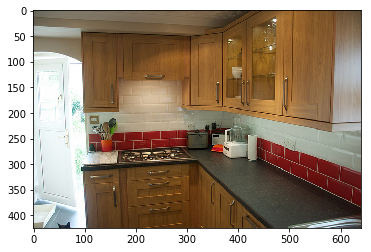

In [52]:
image_id = 25470
print(mscoco_images[image_id])
print(image_annotations[image_id])
image_file_name = '../refer/data/images/mscoco/images/train2014/' + mscoco_images[image_id]
image = io.imread(image_file_name)
plt.imshow(image)

19947

['a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom']
['a', 'blue', 'and', 'white', 'bathroom', 'with', 'butterfly', 'themed', 'wall', 'tiles']
['a', 'bathroom', 'with', 'a', 'border', 'of', 'butterflies', 'and', 'blue', 'paint', 'on', 'the', 'walls', 'above', 'it']
['an', 'angled', 'view', 'of', 'a', 'beautifully', 'decorated', 'bathroom']
['a', 'clock', 'that', 'blends', 'in', 'with', 'the', 'wall', 'hangs', 'in', 'a', 'bathroom']


In [32]:
a = torch.Tensor(3, 3).uniform_(-1, 1)

In [33]:
a


-0.0702  0.1769  0.6411
 0.3706  0.8321 -0.5384
 0.4947 -0.8905  0.9898
[torch.FloatTensor of size 3x3]

In [39]:
torch.mm

<function torch._C.mm>